# Model Workplace! 

- 우선, 정확한 분류기 모델을 만들어봅시다 !
- 모델 구조는 legacy의 mk5를 따라갑시다 !
- mfccs.shape : (1000, 40, 1200) => (Datapoints, MFCC 계수, 시간 프레임)
- 신경망에 LSTM 층을 추가 할 것이기 때문에 데이터 형태를 바꾸어줍시다 !
    - mfccs.shape after transpose: (Datapoints, 시간 프레임, MFCC 계수)

## prepare data

In [69]:
### 데이터 사전 준비 !

import numpy as np
# 데이터 읽기
data = np.load("extracted_mfccs_and_labels.npz")
mfccs = data['mfccs']
labels = data['labels']

print(f'mfccs.shape:{mfccs.shape}')

# 1200은 시간 차원이기 떄문에 자리를 바꿔주자
mfccs = np.transpose(mfccs, (0, 2, 1))

print(f'mfccs.shape after transpose: {mfccs.shape}')

mfccs.shape:(1000, 40, 1200)
mfccs.shape after transpose: (1000, 1200, 40)


In [70]:
### 트 발 테 => 8 : 1 : 1

# train-test split => 8 : 2
from sklearn.model_selection import train_test_split

train_X, test_X, train_y, test_y = train_test_split(
    mfccs,
    labels,
    test_size=0.2,
    random_state=42
)

# validation-test split => 8 : 1 : 1
val_X, test_X, val_y, test_y = train_test_split(
    test_X,
    test_y,
    test_size=0.5,  # validation 세트의 비율을 설정합니다.
    random_state=42
)

print(f'train_X.shape: {train_X.shape}')
print(f'val_X.shape: {val_X.shape}')
print(f'test_X.shape: {test_X.shape}')

train_X.shape: (800, 1200, 40)
val_X.shape: (100, 1200, 40)
test_X.shape: (100, 1200, 40)


In [73]:
### 베이스 모델 
import tensorflow as tf

model = tf.keras.Sequential([
    # Conv로 음악의 지역적 특성을 뽑자
    tf.keras.layers.Conv2D(
        input_shape=(1200, 40, 1),
        filters = 64, 
        kernel_size = (100, 10), 
        strides = (50,1),
        kernel_initializer='glorot_uniform' # 글로럿 초기화 적용
    ),
    # 배치정규화 층 추가
    tf.keras.layers.BatchNormalization(),
    # 배치 정규화는 Nonlinearity 앞에
    tf.keras.layers.Activation('swish'), # swish 사용 !
    # 여기까지 output shape은 (None, 23, 31, 64)  => (23, 31*64)로 reshape
    tf.keras.layers.Reshape(target_shape = (23, 31*64)),
    # LSTM 층 추가
    tf.keras.layers.LSTM(units=23, input_shape=(23, 31*64)), 
    # Dense
    tf.keras.layers.Dense(64, activation='swish',kernel_initializer='glorot_uniform'),
    tf.keras.layers.Dense(32, activation='swish',kernel_initializer='glorot_uniform'),
    # Output Layer <= multi label classification
    tf.keras.layers.Dense(10, activation='sigmoid')
])


model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential_29"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_29 (Conv2D)          (None, 23, 31, 64)        64064     
                                                                 
 batch_normalization_25 (Ba  (None, 23, 31, 64)        256       
 tchNormalization)                                               
                                                                 
 activation_21 (Activation)  (None, 23, 31, 64)        0         
                                                                 
 reshape_13 (Reshape)        (None, 23, 1984)          0         
                                                                 
 lstm_11 (LSTM)              (None, 23)                184736    
                                                                 
 dense_31 (Dense)            (None, 64)                1536      
                                                     

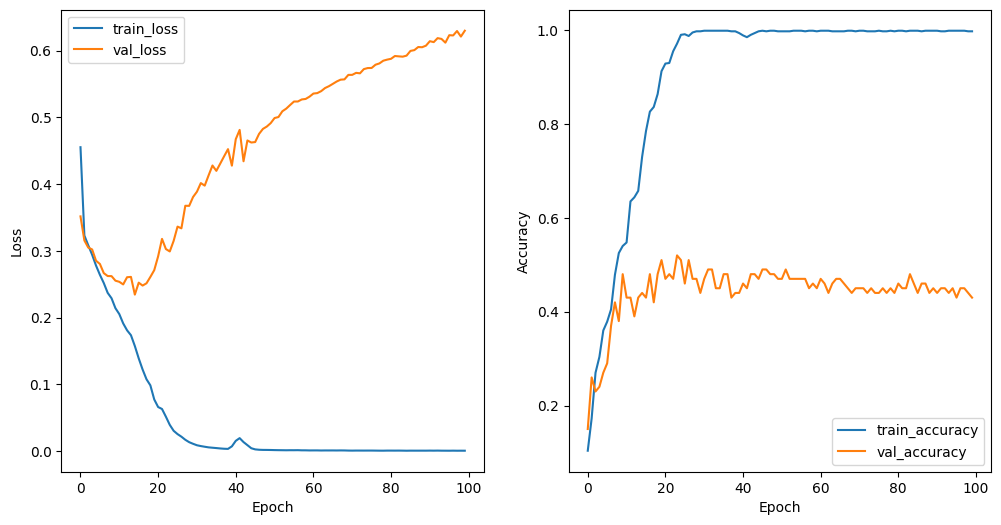

In [74]:
import matplotlib.pyplot as plt
from IPython.display import clear_output # for clear prints


# 학습
history = model.fit(train_X, train_y, validation_data=(val_X, val_y), epochs=100, batch_size=32)
clear_output() # clear prints !

# 학습 결과 시각화
fig, axs = plt.subplots(1,2, figsize=(12, 6))

# Loss 그래프
axs[0].plot(history.history['loss'], label='train_loss')
axs[0].plot(history.history['val_loss'], label='val_loss')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].legend()

# Accuracy 그래프
axs[1].plot(history.history['accuracy'], label='train_accuracy')
axs[1].plot(history.history['val_accuracy'], label='val_accuracy')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Accuracy')
axs[1].legend()

plt.show()


- 예술은 폭발이다 !

## early stopping 추가
- 모델 구조는 대부분 동일
- 다만, Dense에서 Drop-out을 적용
- val loss가 폭주하기 시작하면 학습을 멈추도록 학습 전략을 변경

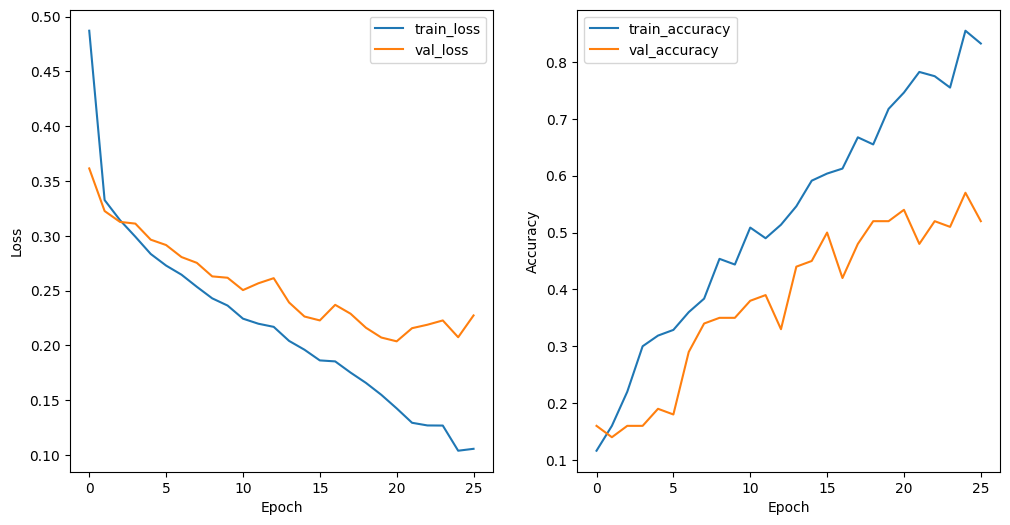

In [20]:
### 데이터 사전 준비 !

import numpy as np
# 데이터 읽기
data = np.load("extracted_mfccs_and_labels.npz")
mfccs = data['mfccs']
labels = data['labels']

print(f'mfccs.shape:{mfccs.shape}')

# 1200은 시간 차원이기 떄문에 자리를 바꿔주자
mfccs = np.transpose(mfccs, (0, 2, 1))

print(f'mfccs.shape after transpose: {mfccs.shape}')





### 트 발 테 => 8 : 1 : 1

# train-test split => 8 : 2
from sklearn.model_selection import train_test_split

train_X, test_X, train_y, test_y = train_test_split(
    mfccs,
    labels,
    test_size=0.2,
    random_state=42
)

# validation-test split => 8 : 1 : 1
val_X, test_X, val_y, test_y = train_test_split(
    test_X,
    test_y,
    test_size=0.5,  # validation 세트의 비율을 설정합니다.
    random_state=42
)

print(f'train_X.shape: {train_X.shape}')
print(f'val_X.shape: {val_X.shape}')
print(f'test_X.shape: {test_X.shape}')





### 베이스 모델 
import tensorflow as tf

model = tf.keras.Sequential([
    # Conv로 음악의 지역적 특성을 뽑자
    tf.keras.layers.Conv2D(
        input_shape=(1200, 40, 1),
        filters = 64, 
        kernel_size = (100, 10), 
        strides = (50,1),
        kernel_initializer='glorot_uniform' # 글로럿 초기화 적용
    ),
    # 배치정규화 층 추가
    tf.keras.layers.BatchNormalization(),
    # 배치 정규화는 Nonlinearity 앞에
    tf.keras.layers.Activation('swish'), # swish 사용 !
    # 여기까지 output shape은 (None, 23, 31, 64)  => (23, 31*64)로 reshape
    tf.keras.layers.Reshape(target_shape = (23, 31*64)),
    # LSTM 층 추가
    tf.keras.layers.LSTM(units=23, input_shape=(23, 31*64)), 
    # Dense
    tf.keras.layers.Dense(64, activation='swish',kernel_initializer='glorot_uniform'),
    tf.keras.layers.Dropout(0.15), # 0.15 drop out 적용
    tf.keras.layers.Dense(32, activation='swish',kernel_initializer='glorot_uniform'),
    # Output Layer <= multi label classification
    tf.keras.layers.Dense(10, activation='sigmoid')
])


model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# model.summary()

import matplotlib.pyplot as plt
from IPython.display import clear_output # for clear prints


# 학습
# early stop 적용

from keras.callbacks import EarlyStopping

# EarlyStopping 콜백 설정
early_stopping = EarlyStopping(monitor='val_loss', 
                               min_delta=0, 
                               patience=5, 
                               verbose=1, 
                               mode='min',
                               restore_best_weights=True)
# 모델 학습
history = model.fit(train_X, train_y, 
                    validation_data=(val_X, val_y), 
                    epochs=100, 
                    batch_size=32,
                    callbacks=[early_stopping])

clear_output() # clear prints !

# 학습 결과 시각화
fig, axs = plt.subplots(1,2, figsize=(12, 6))

# Loss 그래프
axs[0].plot(history.history['loss'], label='train_loss')
axs[0].plot(history.history['val_loss'], label='val_loss')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].legend()

# Accuracy 그래프
axs[1].plot(history.history['accuracy'], label='train_accuracy')
axs[1].plot(history.history['val_accuracy'], label='val_accuracy')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Accuracy')
axs[1].legend()

plt.show()


- 이 정도 결과면 괜찮지 않을까?
- test set 성능 평가 진행

4/4 - 0s - loss: 0.2221 - accuracy: 0.4600 - 80ms/epoch - 20ms/step
Test Loss: 0.22205950319766998
Test Accuracy: 0.46000000834465027
1/1 [==============================] - 0s 367ms/step


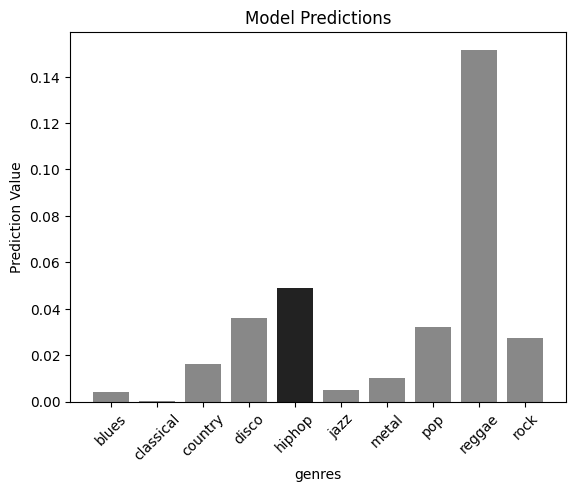

In [21]:
# test 성능 평가 진행

test_loss, test_acc = model.evaluate(test_X, test_y, verbose=2)

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_acc}")

# 실제로는 어떤 결과를 뽑을까?
# test의 index 0 데이터의 결과를 직접 뜯어보자 
import os # 레이블 적기 귀찮아 !

graph_values = model.predict(test_X[0:1,:,:])[0]
graph_labels = os.listdir('music_raw_data')
colors = ['#888888' for _ in range(10)]
for idx, value in enumerate(test_y[0:1,:][0]):
    if value == 1:
        colors[idx] = '#222222' #원래 레이블은 진하게
plt.bar(graph_labels, graph_values, color = colors)

plt.title('Model Predictions')
plt.xlabel('genres')
plt.ylabel('Prediction Value')
plt.xticks(rotation=45)

plt.show()

- 레게라는 장르는 뭘까?
- 실제로 들어보면, 이것도 레게라고? 하는게 많다
- 사실, 레게가 진짜 힙합일 수도 있어 ...
- 음알못인걸까 난

In [22]:
# 모델 저장
model.save('models/mfr_model_re_mk1')

INFO:tensorflow:Assets written to: models/mfr_model_re_mk1\assets


INFO:tensorflow:Assets written to: models/mfr_model_re_mk1\assets
